In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap as cmap
import pygbrowse

import scanpy as sc
import scvelo as scv
from sklearn.neighbors import NearestNeighbors
from harmony import harmonize

from scipy import stats
from tqdm.notebook import tqdm
import ipywidgets
from scipy.ndimage import gaussian_filter
from scipy.signal import gaussian, fftconvolve
from math import ceil, floor

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu 

### Functions

In [2]:
def get_colors_hex(n, colormap='viridis'):
    import matplotlib.colors as mcolors
    cmap = plt.get_cmap(colormap)
    colors = [mcolors.to_hex(cmap(i / n)) for i in range(n)]
    return colors

In [3]:
def scale_to_range(arr, new_min, new_max):
    return new_min + (arr - np.min(arr)) * (new_max - new_min) / (np.percentile(arr, 99) - np.min(arr))

In [4]:
def activating(r, m, tmax=1, k_r=1, alpha=1, r_thresh=1, r_final_p=20):
    """
    Models relocation dynamics as exponential decay and a delayed activation function for transcription. 
    Model uses ordinary differential equations with parameter estimation to reach optimal parameters to fit the observed dynamics. 
    
    Parameters
    ----------
    r : np.array
        relocation measure (order of `r` and `m` must match)
    m : np.array
        mRNA measure (order of `r` and `m` must match)
    tmax : float
           Defines the max point in time at which the solver will compute the values of `r` and `m`
    k_r : float
          relocation rate parameter
    alpha : float
            transcription activation rate parameter
    r_thresh : float
               relocation threshold for transcription activation parameter 
    r_final_p : int
                percentile of final state of `r`
             
    Returns
    -------
    
    """
    from scipy.integrate import odeint
    from scipy.optimize import minimize

    # Define the ODE system with non-linear transcription activation
    def nonlinear_model(y, t, k_r, alpha, r_thresh, r_final):
        r, m = y
        #dr_dt = -k_r * r
        dr_dt = -k_r * (r - r_final)
        # Transcription activation function
        if r > r_thresh:
            activation = 0
        else:
            activation = (r_thresh - r) / r_thresh
        dm_dt = alpha * activation
        return [dr_dt, dm_dt]

    def cost_function(params, t, r, m, r_final):
        k_r, alpha, r_thresh = params
        # Initial conditions for r and m
        y0 = [r.max(), m.min()]
        # Solve the ODEs with optimized parameters 
        sol = odeint(nonlinear_model, y0, t, args=(k_r, alpha, r_thresh, r_final)).T
        r_fit, m_fit = sol
        # Calculate the cost (sum of squared errors)
        cost = np.sum((r - r_fit) ** 2) + np.sum((m - m_fit) ** 2)
        return cost

    #define time along which the ODE will be solved
    t = np.linspace(0, tmax, r.size)

    #final state of `r`, set to 0 for original model
    #TODO: change for `deactivating` 
    #TODO: consider to also subject `r_final_p` to parameter optimization 
    r_final = np.percentile(r, r_final_p)

    # Optimize the parameters to fit the model to the data
    result = minimize(cost_function, (k_r, alpha, r_thresh), args=(t, r, m, r_final))
    k_r_opt, alpha_opt, r_thresh_opt = result.x

    # Initial conditions: `r=r.max()` (fully located near lamina), `m=m.min()` (no transcription)
    y0 = [r.max(), m.min()]

    # Solve the ODE with optimized parameters
    sol = odeint(nonlinear_model, y0, t, args=(k_r_opt, alpha_opt, r_thresh_opt, r_final)).T
    r_fit, m_fit = sol

    return r_fit, m_fit, k_r_opt, alpha_opt, r_thresh_opt

In [5]:
def deactivating(r, m, tmax=1, k_m=1, beta=1, m_thresh=1, r_initial_p=3):
    """
    Models transcription deactivation as exponential decay and a delayed relocation function towards the nuclear body.
    Model uses ordinary differential equations with parameter estimation to reach optimal parameters to fit the observed dynamics.

    Parameters
    ----------
    r : np.array
        Relocation measure (order of `r` and `m` must match)
    m : np.array
        mRNA measure (order of `r` and `m` must match)
    tmax : float
           Defines the max point in time at which the solver will compute the values of `r` and `m`
    k_m : float
          Transcription deactivation rate parameter
    beta : float
           Relocation rate parameter towards nuclear body
    m_thresh : float
               Transcription threshold for relocation activation parameter
    r_start_p : int
                percentile of initial state of `r`

    Returns
    -------
    r_fit, m_fit : np.array
        The fitted values for relocation and transcription over time.
    k_m_opt, beta_opt, m_thresh_opt : float
        The optimized parameters for the model.
    """

    from scipy.integrate import odeint
    from scipy.optimize import minimize

    # Define the ODE system with non-linear relocation after deactivation
    def nonlinear_model(y, t, k_m, beta, m_thresh, ):
        r, m = y
        dm_dt = -k_m * m

        # Relocation function
        if m > m_thresh:
            relocation = 0
        else:
            relocation = (m_thresh - m) / m_thresh

        dr_dt = beta * relocation
        return [dr_dt, dm_dt]

    def cost_function(params, t, r, m, ):
        k_m, beta, m_thresh = params
        # Initial conditions for r and m
        y0 = [r.min(), m.max()]
        # Solve the ODEs with optimized parameter
        sol = odeint(nonlinear_model, y0, t, args=(k_m, beta, m_thresh, )).T
        r_fit, m_fit = sol
        # Calculate the cost (sum of squared errors)
        cost = np.sum((r - r_fit) ** 2) + np.sum((m - m_fit) ** 2)
        return cost

    # Define time along which the ODE will be solved
    t = np.linspace(0, tmax, r.size)

    # Optimize the parameters to fit the model to the data
    result = minimize(cost_function, (k_m, beta, m_thresh), args=(t, r, m, ))
    k_m_opt, beta_opt, m_thresh_opt = result.x

    # Initial conditions: `r=r.min()` (fully away from nuclear body), `m=m.max()` (full transcription)
    y0 = [np.percentile(r, r_initial_p), m.max()]

    # Solve the ODE with optimized parameters
    sol = odeint(nonlinear_model, y0, t, args=(k_m_opt, beta_opt, m_thresh_opt, )).T
    r_fit, m_fit = sol

    return r_fit, m_fit, k_m_opt, beta_opt, m_thresh_opt

In [6]:
def refine_fits(r, m, r_fit, m_fit):
    
    from scipy.interpolate import interp1d

    # Create an interpolating function
    fitted_line_func = interp1d(r_fit, m_fit, kind='linear', fill_value="extrapolate")
    
    #in case of relocation followed by activation, trajectory goes from lower right to upper left 
    r_lin = np.linspace(r.min(),r.max(),100000) #initial large number of steps required for high-resolution prediction of intersection
    m_lin = np.linspace(m.max(),m.min(),100000)
    
    #predict `m` for `r_lin` based on `fitted_line_func` 
    m_predict = fitted_line_func(r_lin)
    
    #calculate distances to get intersect of linear and exponential fits
    a = r_lin - r_lin
    b = m_lin - m_predict
    dist = np.sqrt(a**2 + b**2)
    
    #define intersect as point with shortest distance within 90th percetnile --> change with downregulation or Dam126 dynamics 
    intersect_idx = dist[r_lin < np.percentile(r_lin, 60)].argmin()
    r_intersect = r_lin[intersect_idx]
    m_intersect = m_lin[intersect_idx]
    
    #refined linear fit
    r_lin_refined = np.linspace(r_intersect,r.max(),100000)
    m_lin_refined = np.linspace(m_intersect,m.min(),100000)
    
    #refine model fit 
    r_fit_refined = r_lin_refined
    m_fit_refined = fitted_line_func(r_lin_refined)
    
    #reduce size of fits by taking every nth element
    n = 100
    r_lin_refined = r_lin_refined[0::n]
    m_lin_refined = m_lin_refined[0::n]
    
    r_fit_refined = r_fit_refined[0::n]
    m_fit_refined = m_fit_refined[0::n]

    return r_lin_refined, m_lin_refined, r_fit_refined, m_fit_refined, r_intersect, m_intersect

### Plot

In [8]:
COLORS = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# presentation style
plt.matplotlib.rcParams['font.weight'] = 'normal'
plt.matplotlib.rcParams['axes.titleweight'] = 'normal'
plt.matplotlib.rcParams['axes.facecolor'] = plt.matplotlib.colors.to_hex((1., 1., 1., 1.), keep_alpha=True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = .25

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

OUTDIR = '/Users/prullens/Documents/manuscripts/invivo/figure3/'

### Global variables

In [9]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]

BINSIZE = 100000
SMOOTH_STDDEV = 150000

CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5'

chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(int).to_dict()

DAMIDFN_BASE = '/Users/prullens/Documents/projects/invivo/experiments/{}/hdf5/{}.index{:02d}.DamID2_BC_{:03d}.top_n_2.event_counts.binsize_{}.hdf5'

### Data

In [10]:
adata = sc.read_h5ad('/Users/prullens/data/projects/invivo/singlecell_lads_mouse_cortex.h5ad.gz')

adata

AnnData object with n_obs × n_vars = 5612 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    uns: 'cell_type_colors', 'construct_colors', 'construct_flattened_colors', 'embryo_colors', 'iue_colors', 'leiden_colors', 'limsid_colors', 'neighbors', 'rank_genes_groups', 'rank_genes_groups_cell_type'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'damid', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distanc

_dyn-i/LAD genes_

In [51]:
gene_class = pd.read_csv('/Users/prullens/Documents/projects/invivo/PR20241108.ilad_lad_genes_activating_deactivating_balanced.tsv', sep='\t')

gene_class.shape

(677, 6)

### Plot

In [11]:
adata.uns['cell_type_colors'] = np.array(['#1B7837', #PN1
                                          '#00441B',#PN2
                                          '#053061', #apical_progenitors
                                       '#4393C3', #intermediate_progenitors
                                       '#2020DF', #interneurons
                                       '#AFA5CF', #migrating_neurons
                                       '#543005'], #red_blood_cells
                                      dtype=object
)

In [12]:
cell_type_colors = dict(zip(adata.obs['cell_type'].cat.categories,adata.uns['cell_type_colors']))

cell_type_colors

{'PN1': '#1B7837',
 'PN2': '#00441B',
 'apical_progenitors': '#053061',
 'intermediate_progenitors': '#4393C3',
 'interneurons': '#2020DF',
 'migrating_neurons': '#AFA5CF',
 'red_blood_cells': '#543005'}

In [13]:
cell_types = ['apical_progenitors','intermediate_progenitors','migrating_neurons','PN1','PN2']

cell_types, len(cell_types)

(['apical_progenitors',
  'intermediate_progenitors',
  'migrating_neurons',
  'PN1',
  'PN2'],
 5)

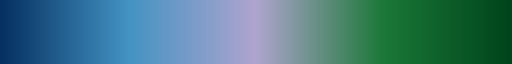

In [14]:
cell_types_cmap = cmap.from_list('',[cell_type_colors[cell_type] for cell_type in cell_types])

cell_types_cmap

____

_____

In [15]:
scv.pp.moments(adata, 
               n_pcs=30, 
               n_neighbors=30, 
               add_layers=['count_abundance_genes_from_celseq2_data'],
               use_rep='X_pca_harmony'
)

computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)


### Trajectory dynamics 

In [16]:
anno_sub = adata.obs[adata.obs['damid']].copy()

anno_sub.shape

(4192, 27)

_Dam-Lamin B1_

In [17]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna()) & (anno_sub['construct_flattened'] == 'Dam-LMNB1')].sort_values('monocle_pseudotime').index

adata_lb1 = sc.AnnData(adata[bcs].X, obs=adata[bcs].obs, var=adata[bcs].var)
adata_lb1.layers['count_abundance_genes_from_celseq2_data'] = adata[bcs].layers['count_abundance_genes_from_celseq2_data']
adata_lb1.layers['spliced'] = adata[bcs].layers['spliced']
adata_lb1.layers['unspliced'] = adata[bcs].layers['unspliced']
adata_lb1.layers['damid'] = adata[bcs].layers['damid']

adata_lb1.obsm['X_umap'] = adata_lb1.obs[['UMAP1','UMAP2']].values

adata_lb1

AnnData object with n_obs × n_vars = 2139 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    obsm: 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'spliced', 'unspliced', 'damid'

In [18]:
sc.tl.pca(adata_lb1, use_highly_variable=True, svd_solver='arpack', n_comps=100, random_state=0)

In [19]:
Z = harmonize(adata_lb1.obsm['X_pca'], adata_lb1.obs, batch_key = 'limsid', random_state=0)
adata_lb1.obsm['X_pca_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [20]:
scv.pp.moments(adata_lb1, add_layers=['count_abundance_genes_from_celseq2_data','damid'], 
               n_pcs=30, 
               n_neighbors=30, 
               use_rep='X_pca_harmony'
)

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)
--> added 
    'Md' moments of damid abundances (adata.layers)


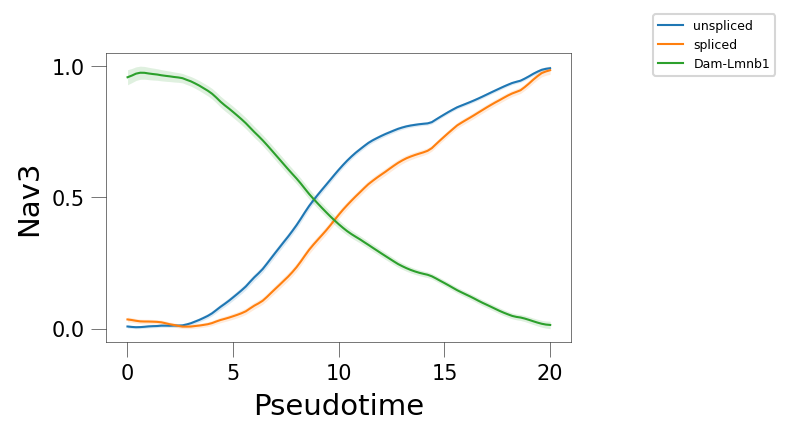

In [41]:
for var_name in ['Nav3']:
    f, ax = plt.subplots(figsize=(4,2.5))

    #RNA
    for i,layer in enumerate(['Mu','Ms']):
        obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
        X = adata[obs_names].obs['monocle_pseudotime']
        Mc = np.ravel(adata[obs_names,var_name].layers[layer].toarray())

        xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                        y=Mc, 
                                        _RADIUS=2, 
                                        step=.2
        )
        yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
        yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
        yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

        ax.plot(xhat, 
                yhat, 
                lw=1,
                color=COLORS[i], 
                label=['unspliced','spliced'][i]
        )
        ax.fill_between(xhat, 
                        yhat_sem_min, 
                        yhat_sem_plus, 
                        color=COLORS[i], 
                        alpha=.15,
                        lw=0
        )

    #Dam-LMNB1
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var_name].layers['Md'].toarray())
    #_idx = d > d.min()

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )

    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    ax.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[i+1],
            label='Dam-Lmnb1'
    )
    ax.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[i+1], 
                    alpha=.15,
                    lw=0
    )

    ax.set_ylabel(var_name, fontsize=14)
    ax.set_xlabel('Pseudotime', fontsize=14)
    ax.set_yticks([0,.5,1])
    ax.set_yticks([0,.5,1])
    f.legend(prop={'size':6}, bbox_to_anchor=(1.25,1))

____

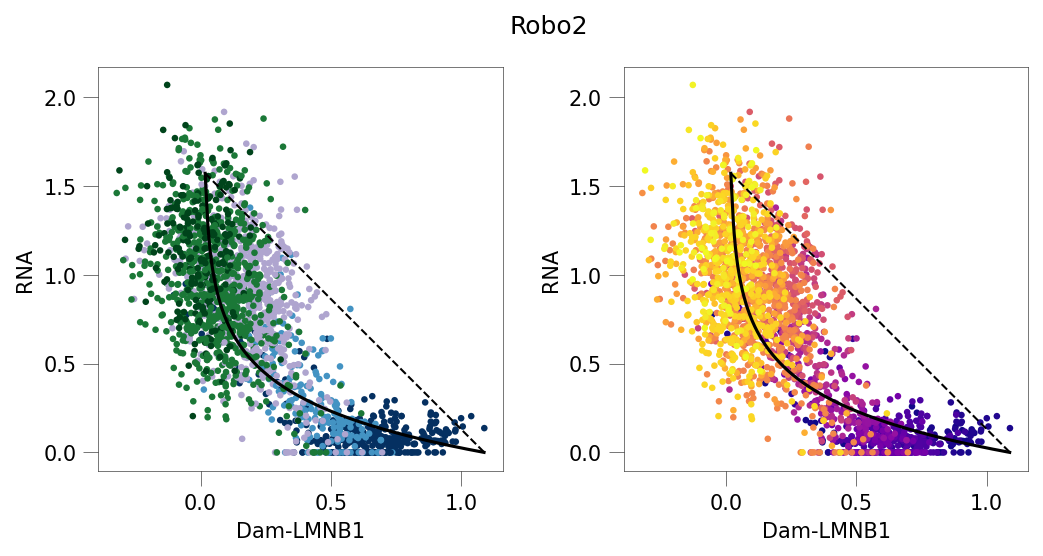

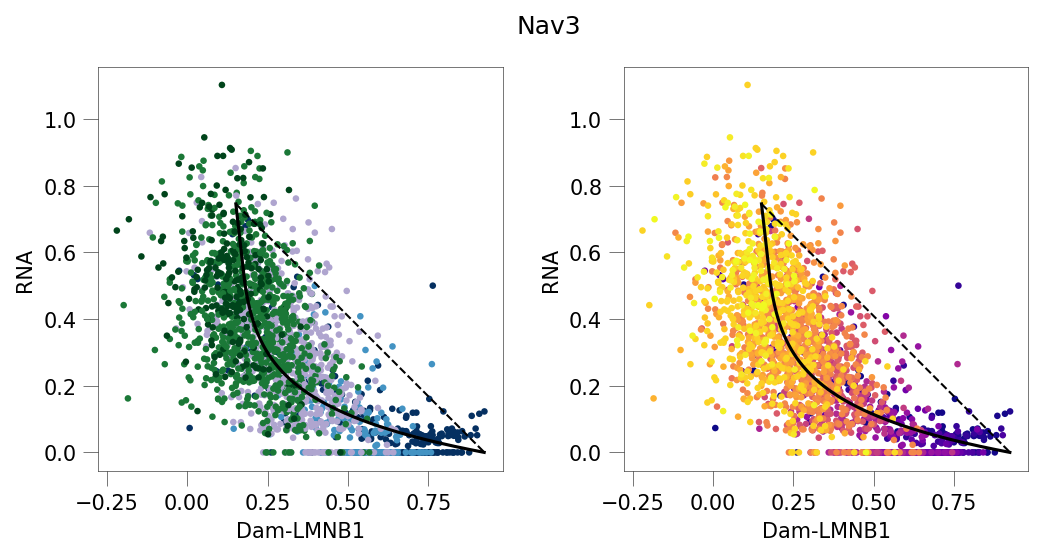

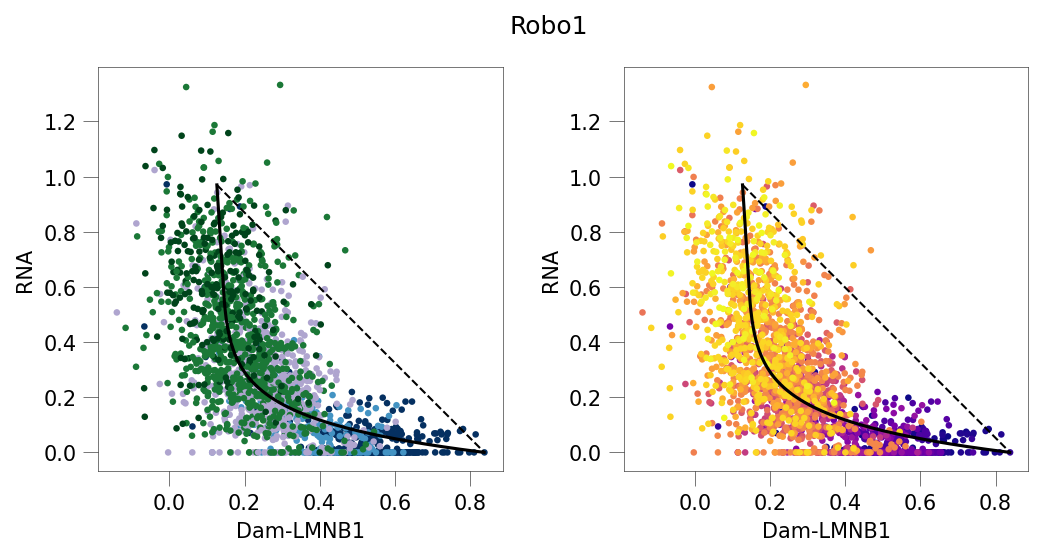

In [27]:
for var_name in ['Robo2','Nav3','Robo1']:
    Mc = np.ravel(adata_lb1[:,var_name].layers['Mc'].toarray())
    Md = np.ravel(adata_lb1[:,var_name].layers['Md'].toarray())

    r_fit, m_fit, k_r_opt, alpha_opt, r_thresh_opt = activating(Md, Mc, r_final_p=20)
    r_lin_refined, m_lin_refined, r_fit_refined, m_fit_refined, r_intersect, m_intersect = refine_fits(Md, Mc, r_fit, m_fit)

    f, ax = plt.subplots(1, 2, figsize=(8,3.5), gridspec_kw={'wspace':.3})

    sns.scatterplot(x=Md, 
                    y=Mc, 
                    hue=adata_lb1.obs['cell_type'], 
                    hue_order=adata.obs['cell_type'].cat.categories,
                    palette=adata.uns['cell_type_colors'],
                    lw=0, 
                    s=10, 
                    legend=False,
                    ax=ax[0]
    )
    ax[1].scatter(Md, 
                  Mc, 
                  c=adata_lb1.obs['monocle_pseudotime'], 
                  s=10, 
                  cmap='plasma', 
                  lw=0,
    )
    for i in range(ax.size):
        #ax[0].plot([Md.min(),Md.max()], [Mc.max(),Mc.min()], color='k', ls='--', lw=1)
        ax[i].plot(r_lin_refined, m_lin_refined, color='k', ls='--', lw=1, label='refined linear')
        ax[i].plot(r_fit_refined, m_fit_refined, color='k', label='refined fit')

    ax[0].set_xlabel('Dam-LMNB1')
    ax[0].set_ylabel('RNA')
    ax[1].set_xlabel('Dam-LMNB1')

    ax[1].set_ylabel('RNA')

    f.suptitle(var_name)

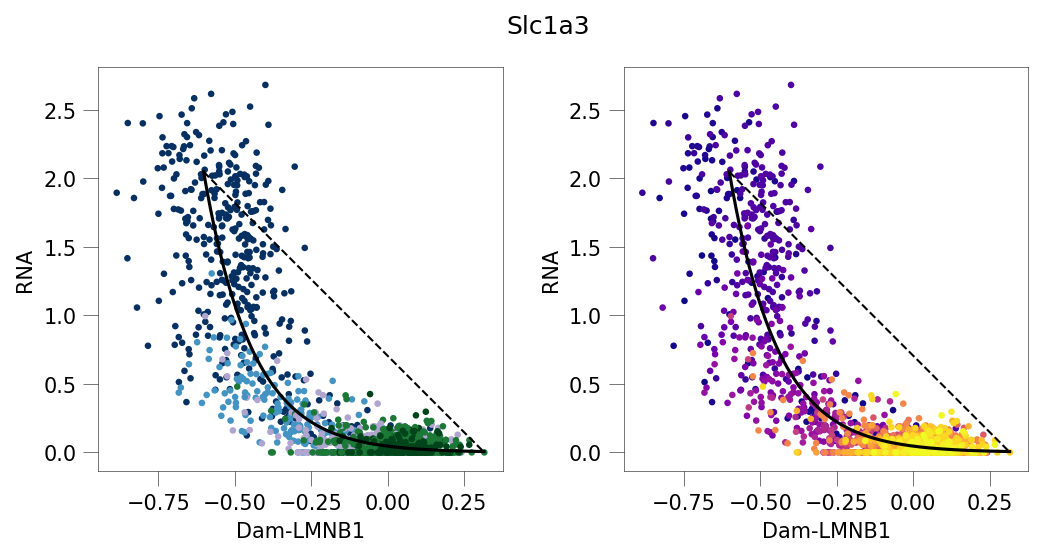

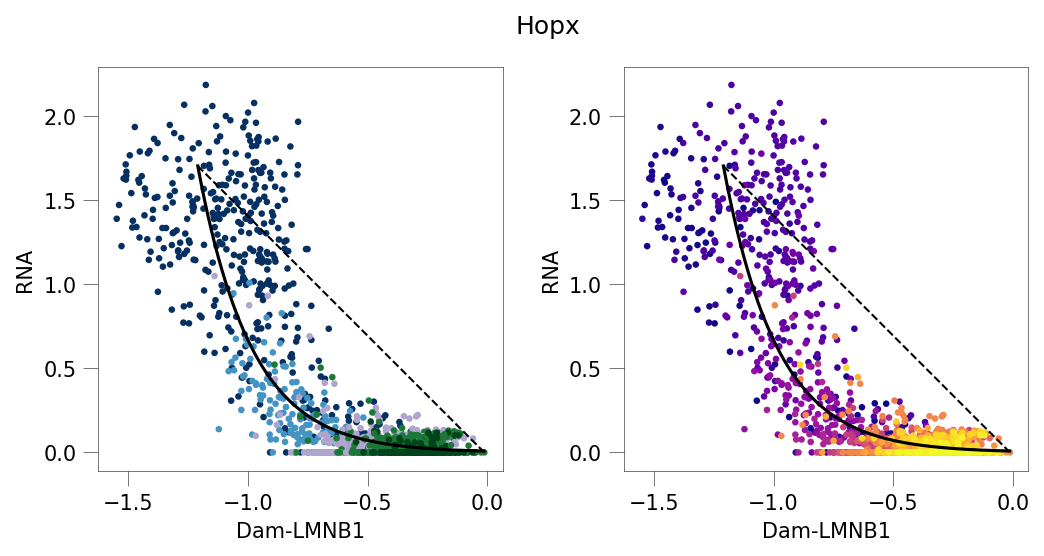

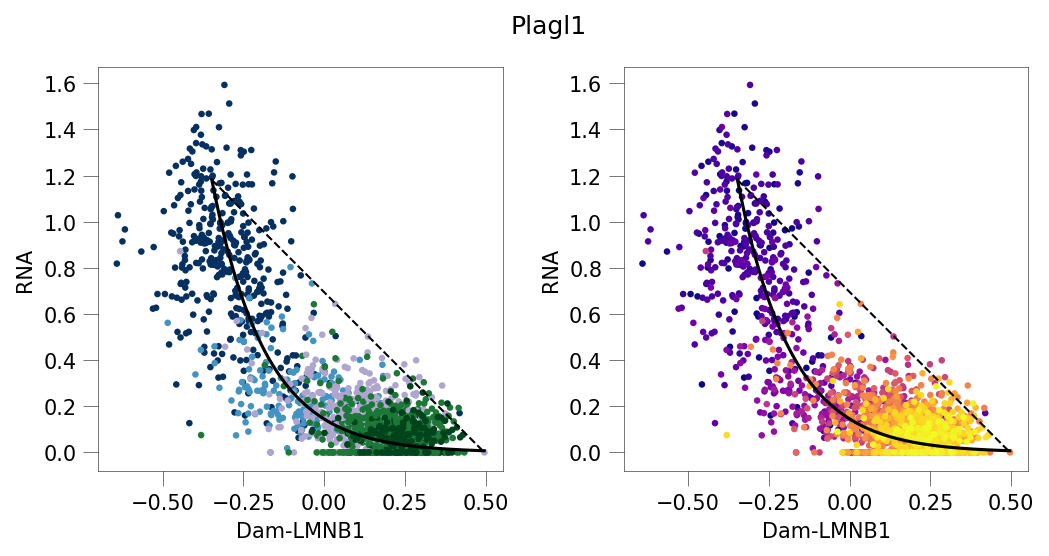

In [28]:
for var_name in ['Slc1a3','Hopx','Plagl1']:
    Mc = np.ravel(adata_lb1[:,var_name].layers['Mc'].toarray())
    Md = np.ravel(adata_lb1[:,var_name].layers['Md'].toarray())

    r_fit, m_fit, k_r_opt, alpha_opt, r_thresh_opt = deactivating(Md, Mc, r_initial_p=3)
    r_lin_refined, m_lin_refined, r_fit_refined, m_fit_refined, r_intersect, m_intersect = refine_fits(Md, Mc, r_fit, m_fit)

    f, ax = plt.subplots(1, 2, figsize=(8,3.5), gridspec_kw={'wspace':.3})

    sns.scatterplot(x=Md, 
                    y=Mc, 
                    hue=adata_lb1.obs['cell_type'], 
                    hue_order=adata.obs['cell_type'].cat.categories,
                    palette=adata.uns['cell_type_colors'],
                    lw=0, 
                    s=10, 
                    legend=False,
                    ax=ax[0]
    )
    ax[1].scatter(Md, 
                  Mc, 
                  c=adata_lb1.obs['monocle_pseudotime'], 
                  s=10, 
                  cmap='plasma', 
                  lw=0,
    )
    for i in range(ax.size):
        #ax[0].plot([Md.min(),Md.max()], [Mc.max(),Mc.min()], color='k', ls='--', lw=1)
        ax[i].plot(r_lin_refined, m_lin_refined, color='k', ls='--', lw=1, label='refined linear')
        ax[i].plot(r_fit_refined, m_fit_refined, color='k', label='refined fit')

    ax[0].set_xlabel('Dam-LMNB1')
    ax[0].set_ylabel('RNA')
    ax[1].set_xlabel('Dam-LMNB1')

    ax[1].set_ylabel('RNA')

    f.suptitle(var_name)

    plt.show()

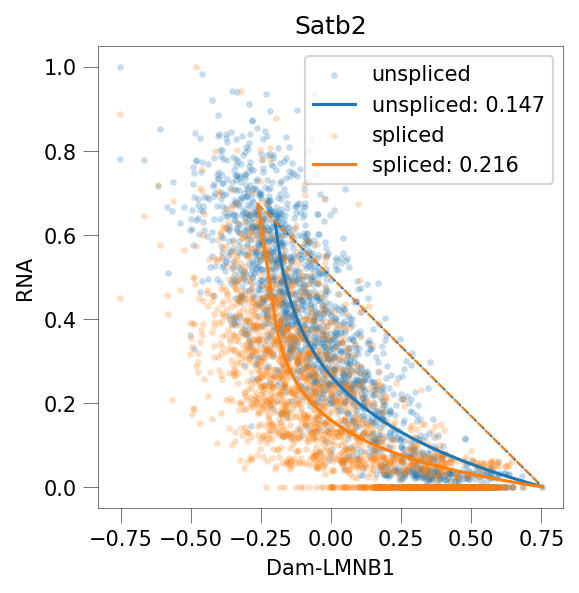

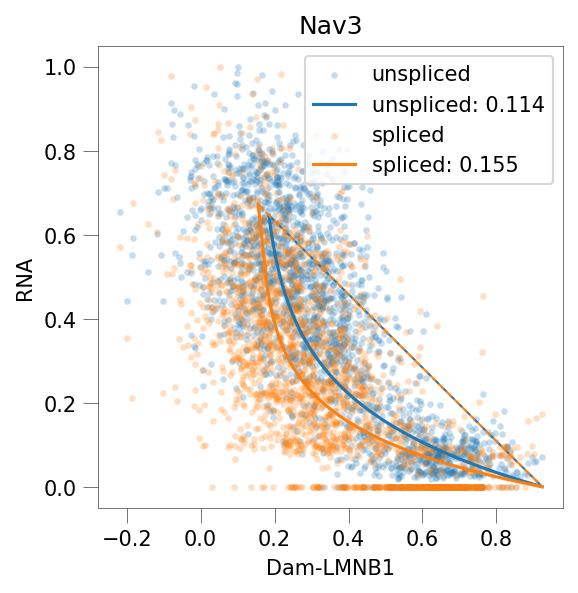

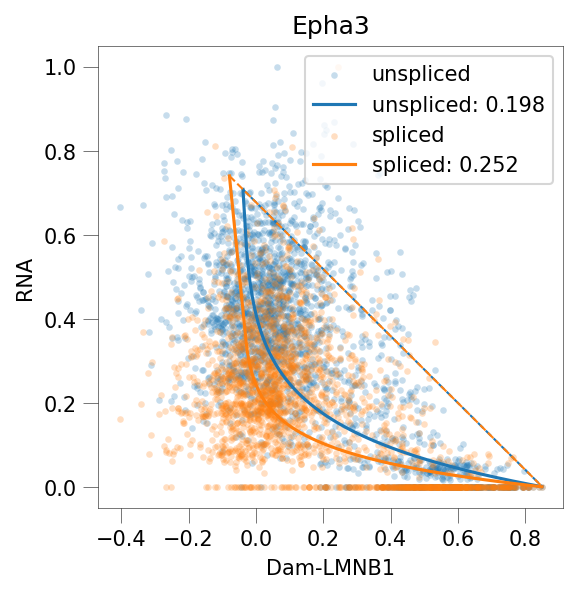

In [97]:
for var_name in ['Satb2','Nav3','Epha3']:
    Md = np.ravel(adata_lb1[:,var_name].layers['Md'].toarray())

    f, ax = plt.subplots(figsize=(4,4))

    for i,layer in enumerate(['Mu','Ms']):

        Ml = np.ravel(adata_lb1[:,var_name].layers[layer].toarray())
        Ml = sccu.mmscale(Ml)

        r_fit, m_fit, k_r_opt, alpha_opt, r_thresh_opt = activating(Md, Ml, r_final_p=20)
        r_lin_refined, m_lin_refined, r_fit_refined, m_fit_refined, r_intersect, m_intersect = refine_fits(Md, Ml, r_fit, m_fit)

        area = np.trapz(m_lin_refined - m_fit_refined, r_lin_refined)

        sns.scatterplot(x=Md, 
                        y=Ml, 
                        color=COLORS[i],
                        lw=0, 
                        s=10, 
                        alpha=.25,
                        label=['unspliced','spliced'][i],
                        legend=False,
        )

        ax.plot(r_lin_refined, m_lin_refined, color=COLORS[i], ls='--', lw=1)
        ax.plot(r_fit_refined, m_fit_refined, color=COLORS[i], label=f"{['unspliced','spliced'][i]}: {area:.3f}")

    ax.set_xlabel('Dam-LMNB1')
    ax.set_ylabel('RNA')

    ax.legend()
    ax.set_title(var_name)

_____

In [29]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna()) & (anno_sub['construct_flattened'] == 'Dam-only')].sort_values('monocle_pseudotime').index

adata_dam = sc.AnnData(adata[bcs].X, obs=adata[bcs].obs, var=adata[bcs].var)
adata_dam.layers['count_abundance_genes_from_celseq2_data'] = adata[bcs].layers['count_abundance_genes_from_celseq2_data']
adata_dam.layers['spliced'] = adata[bcs].layers['spliced']
adata_dam.layers['unspliced'] = adata[bcs].layers['unspliced']
adata_dam.layers['damid'] = adata[bcs].layers['damid']

adata_dam.obsm['X_umap'] = adata_dam.obs[['UMAP1','UMAP2']].values

adata_dam

AnnData object with n_obs × n_vars = 1664 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    obsm: 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'spliced', 'unspliced', 'damid'

In [30]:
sc.tl.pca(adata_dam, use_highly_variable=True, svd_solver='arpack', n_comps=100, random_state=0)

In [31]:
Z = harmonize(adata_dam.obsm['X_pca'], adata_dam.obs, batch_key = 'limsid', random_state=0)
adata_dam.obsm['X_pca_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [32]:
scv.pp.moments(adata_dam, add_layers=['count_abundance_genes_from_celseq2_data','damid'], 
               n_pcs=30, 
               n_neighbors=50, 
               use_rep='X_pca_harmony'
)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)
--> added 
    'Md' moments of damid abundances (adata.layers)


_____

Text(0.5, 0.98, 'Robo1')

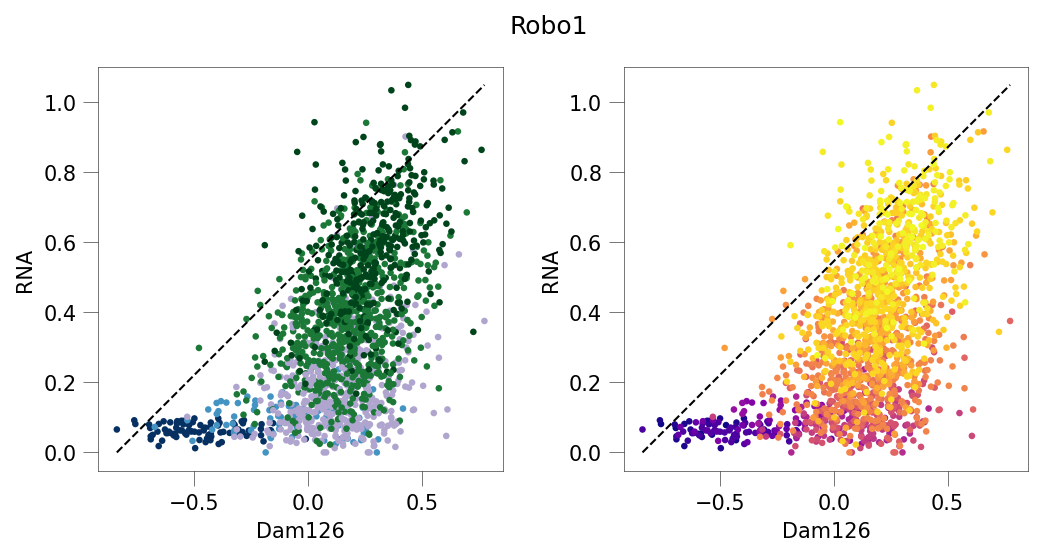

In [33]:
var_name = 'Robo1'

Mc = np.ravel(adata_dam[:,var_name].layers['Mc'].toarray())
Md = np.ravel(adata_dam[:,var_name].layers['Md'].toarray())

f, ax = plt.subplots(1, 2, figsize=(8,3.5), gridspec_kw={'wspace':.3})

sns.scatterplot(x=Md, 
                y=Mc, 
                hue=adata_dam.obs['cell_type'], 
                hue_order=adata.obs['cell_type'].cat.categories,
                palette=adata.uns['cell_type_colors'],
                lw=0, 
                s=10, 
                legend=False,
                ax=ax[0]
)
ax[1].scatter(Md, 
              Mc, 
              c=adata_dam.obs['monocle_pseudotime'], 
              s=10, 
              cmap='plasma', 
              lw=0,
)
for i in range(ax.size):
    ax[i].plot([Md.min(),Md.max()], [Mc.min(),Mc.max()], color='k', ls='--', lw=1)

ax[0].set_xlabel('Dam126')
ax[0].set_ylabel('RNA')
ax[1].set_xlabel('Dam126')

ax[1].set_ylabel('RNA')

f.suptitle(var_name)

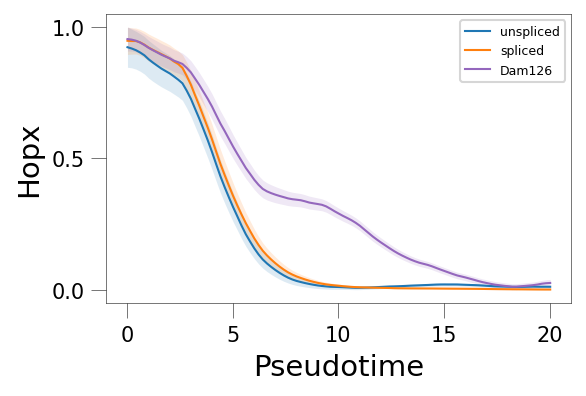

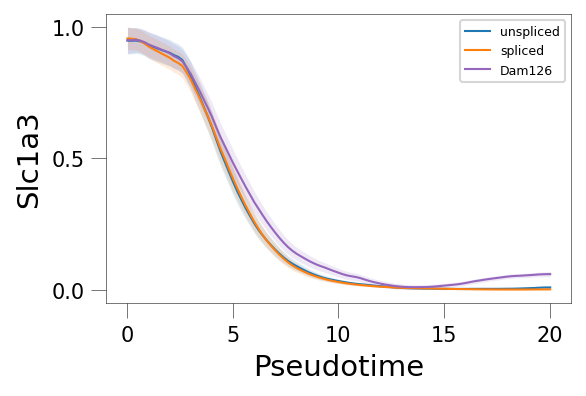

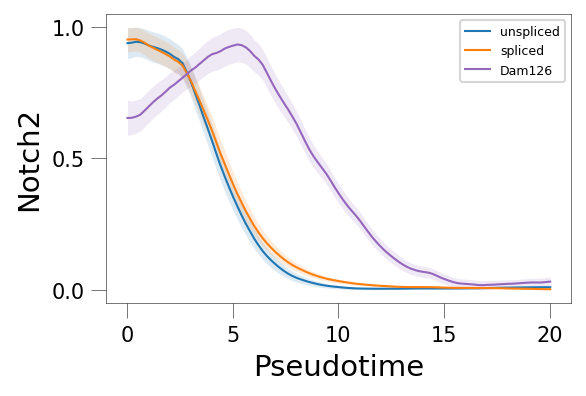

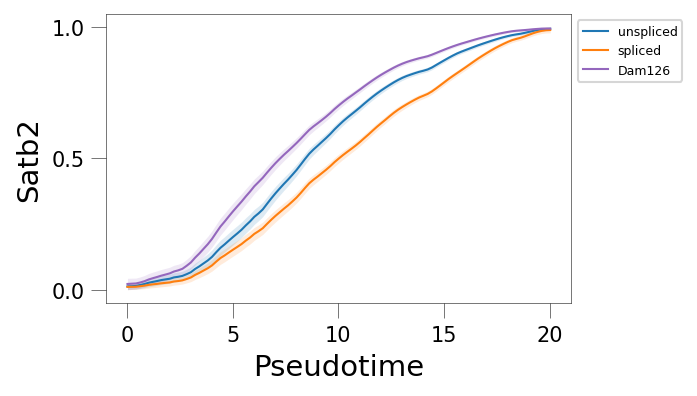

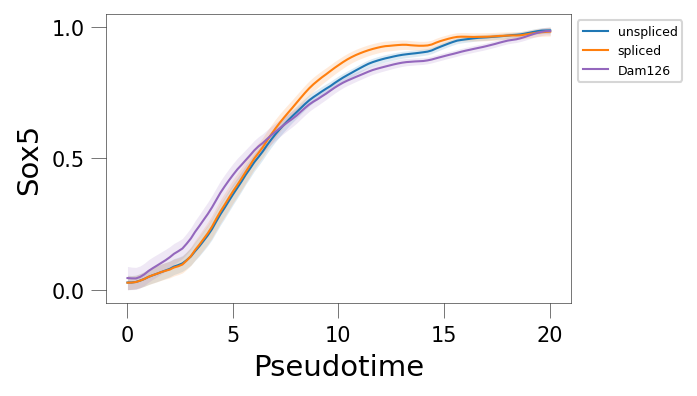

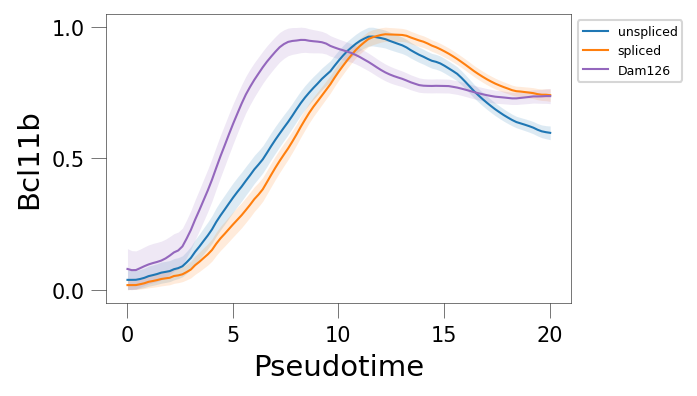

In [40]:
var_name = 'Bcl11b'

for var_name in ['Hopx','Slc1a3','Notch2','Satb2','Sox5','Bcl11b']:
    f, ax = plt.subplots(figsize=(4,2.5))

    #RNA
    for i,layer in enumerate(['Mu','Ms']):
        X = adata_dam.obs['monocle_pseudotime']
        Mc = np.ravel(adata_dam[:,var_name].layers[layer].toarray())

        xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                        y=Mc, 
                                        _RADIUS=2, 
                                        step=.2
        )
        yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
        yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
        yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

        ax.plot(xhat, 
                yhat, 
                lw=1,
                color=COLORS[i], 
                label=['unspliced','spliced'][i]
        )
        ax.fill_between(xhat, 
                        yhat_sem_min, 
                        yhat_sem_plus, 
                        color=COLORS[i], 
                        alpha=.15,
                        lw=0
        )

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var_name].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    ax.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[4],
            label='Dam126'
    )
    ax.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[4], 
                    alpha=.15,
                    lw=0
    )

    ax.set_ylabel(var_name, fontsize=14)
    ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))
    ax.set_xlabel('Pseudotime', fontsize=14)
    ax.set_yticks([0,.5,1])

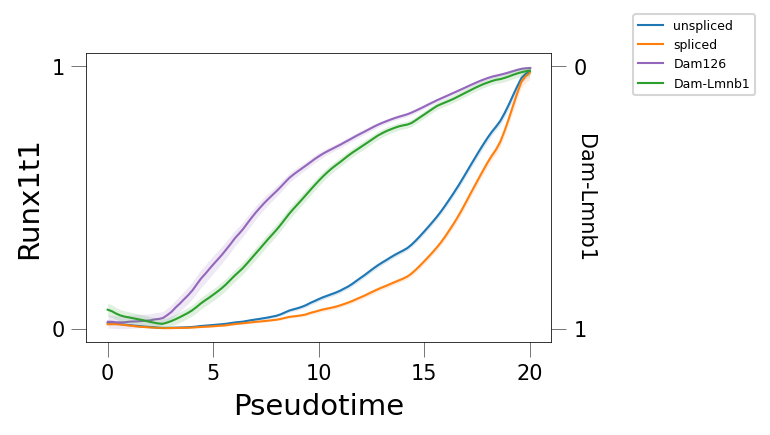

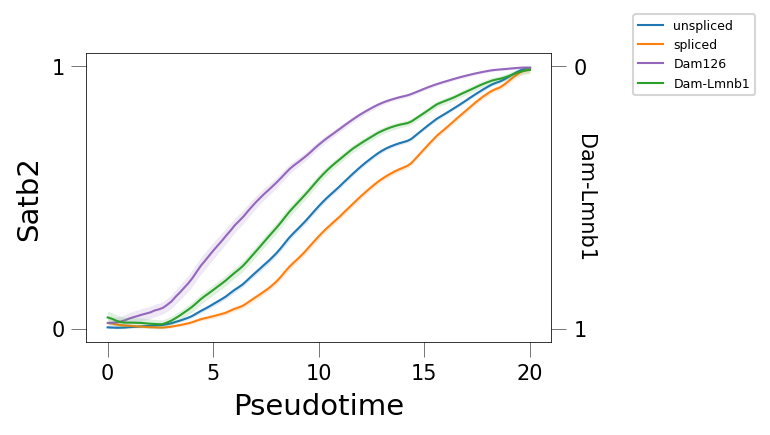

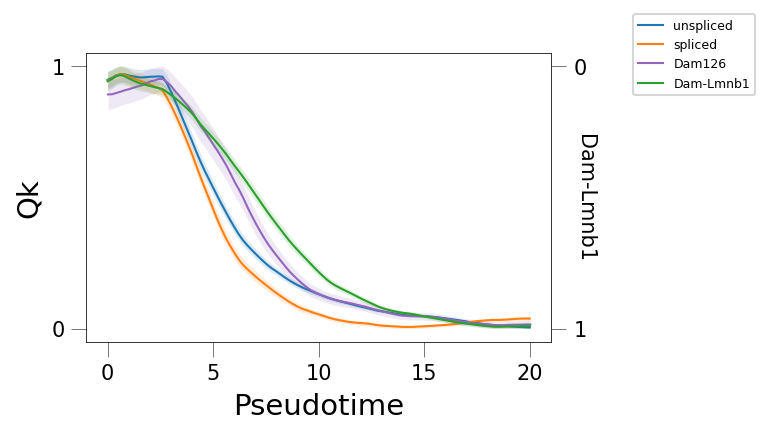

In [48]:
for var in ['Runx1t1','Satb2','Qk']:
    f, ax = plt.subplots(figsize=(4,2.5))

    #RNA
    for i,layer in enumerate(['Mu','Ms']):
        obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
        X = adata[obs_names].obs['monocle_pseudotime']
        Mc = np.ravel(adata[obs_names,var].layers[layer].toarray())

        xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                        y=Mc, 
                                        _RADIUS=2, 
                                        step=.2
        )
        yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
        yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
        yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

        ax.plot(xhat, 
                yhat, 
                lw=1,
                color=COLORS[i], 
                label=['unspliced','spliced'][i]
        )
        ax.fill_between(xhat, 
                        yhat_sem_min, 
                        yhat_sem_plus, 
                        color=COLORS[i], 
                        alpha=.15,
                        lw=0
        )

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    ax.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[4],
            label='Dam126'
    )
    ax.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[4], 
                    alpha=.15,
                    lw=0
    )

    #Dam-LMNB1
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var].layers['Md'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )

    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())

    #plot Dam-lb1 to right y-axis
    ax1 = ax.twinx()

    ax1.plot(xhat, 
            yhat, 
            lw=1,
            color=COLORS[i+1],
            label='Dam-Lmnb1'
    )
    ax1.fill_between(xhat, 
                    yhat_sem_min, 
                    yhat_sem_plus, 
                    color=COLORS[i+1], 
                    alpha=.15,
                    lw=0
    )
    ax1.invert_yaxis()

    ax.set_ylabel(var, fontsize=14)
    ax.set_xlabel('Pseudotime', fontsize=14)
    ax.set_yticks([0,1])
    ax1.set_yticks([0,1])
    ax1.set_ylabel('Dam-Lmnb1', rotation=-90)
    f.legend(prop={'size':6}, bbox_to_anchor=(1.25,1))
    plt.show()

____

### Generalize dynamics 

In [52]:
var_names_lad = gene_class.loc[gene_class['class'] == 'LAD','Gene'].values

var_names_lad.size

364

In [53]:
#RNA expression
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna())].sort_values('monocle_pseudotime').index
X = adata[bcs].obs['monocle_pseudotime']

step = .1
exp_a2d = np.zeros((var_names_lad.size, int(X.max() / step) + 1))
for i,y in enumerate(tqdm(adata[bcs,var_names_lad].layers['count_abundance_genes_from_celseq2_data'].toarray().T)):
    var = var_names_lad[i]
    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=y, 
                                    _RADIUS=2, 
                                    step=step
    )
    exp_a2d[i] = yhat
    
exp_df_mmscale = pd.DataFrame(sccu.mmscale(exp_a2d, axis=1), 
                              index=var_names_lad
)

xhat_heatmap = xhat.copy()

  0%|          | 0/364 [00:00<?, ?it/s]

In [54]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna()) & (anno_sub['construct_flattened'] == 'Dam-LMNB1')].sort_values('monocle_pseudotime').index
X = adata[bcs].obs['monocle_pseudotime']

step = .1
damlb1_a2d = np.zeros((var_names_lad.size, int(X.max() / step) + 1))
for i,y in enumerate(tqdm(adata[bcs,var_names_lad].layers['damid'].toarray().T)):
    _idx = y > y.min()
    xhat, yhat, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=y[_idx], 
                                    _RADIUS=4, 
                                    step=step
    )
    damlb1_a2d[i] = yhat
    
damlb1_df_mmscale = pd.DataFrame(sccu.mmscale(damlb1_a2d, axis=1), 
                                 index=var_names_lad
)

  0%|          | 0/364 [00:00<?, ?it/s]

In [55]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna()) & (anno_sub['construct_flattened'] == 'Dam-only')].sort_values('monocle_pseudotime').index
X = adata[bcs].obs['monocle_pseudotime']

step = .1
dam_a2d = np.zeros((var_names_lad.size, int(X.max() / step) + 1))
for i,y in enumerate(tqdm(adata[bcs,var_names_lad].layers['damid'].toarray().T)):
    _idx = y > y.min()
    xhat, yhat, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=y[_idx], 
                                    _RADIUS=4.5, 
                                    step=step
    )
    try:
        dam_a2d[i] = yhat
    except ValueError:
        print('exception',yhat.size)
        dam_a2d[i] = np.r_[yhat,[yhat[-1]]*(dam_a2d.shape[-1] - yhat.size)]
    
dam_df_mmscale = pd.DataFrame(sccu.mmscale(dam_a2d, axis=1), 
                                 index=var_names_lad
)

  0%|          | 0/364 [00:00<?, ?it/s]

exception 201
exception 201
exception 201
exception 201
exception 201
exception 200
exception 201
exception 201
exception 201
exception 201
exception 200


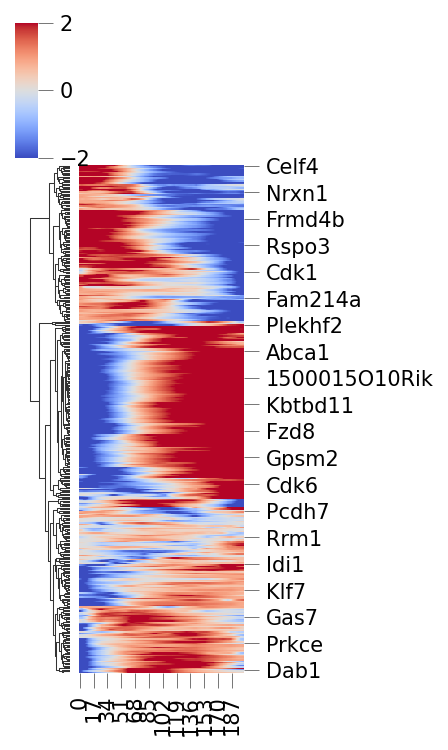

In [56]:
ratio = np.log2(((damlb1_df_mmscale + .1) + (damlb1_df_mmscale + .1))  / 
                ((exp_df_mmscale + .1) + (dam_df_mmscale + .1)))

cg = sns.clustermap(ratio, 
                    col_cluster=False, 
                    vmin=-2, 
                    vmax=2,
                    cmap='coolwarm', 
               figsize=(3,5),
)

In [57]:
reordered_ind = cg.dendrogram_row.reordered_ind[::-1]

In [74]:
idxs = np.where(np.isin(var_names_lad[reordered_ind],['Celf4','Cenpc1']))[0]

activating_var_names = var_names_lad[reordered_ind][idxs[0]:idxs[1]]
activating_var_names = gene_class.set_index('Gene').loc[activating_var_names].groupby('trend').groups['activating']

activating_var_names = np.intersect1d(gene_class.loc[(gene_class['class'] == 'LAD') & (
    gene_class['pearsonr_rna'] > .8),'Gene'], 
                                       activating_var_names
)

activating_var_names.size

75

In [75]:
idxs = np.where(np.isin(var_names_lad[reordered_ind],['Gen1','Cdkn2c']))[0]

deactivating_var_names = var_names_lad[reordered_ind][idxs[0]:idxs[1]]
deactivating_var_names = gene_class.set_index('Gene').loc[deactivating_var_names].groupby('trend').groups['deactivating']

deactivating_var_names.size

123

In [60]:
min_ywindow = 0.4
max_ywindow = 0.6

xhat_size = 101 #hard-coded, depends on `int(pseudotime.max() / step) + 1)`

xhat2d_corrected_rna = np.zeros((activating_var_names.size,xhat_size))
yhat2d_rna = np.zeros((activating_var_names.size,xhat_size))

xhat2d_corrected_lb1 = np.zeros((activating_var_names.size,xhat_size))
yhat2d_lb1 = np.zeros((activating_var_names.size,xhat_size))

xhat2d_corrected_dam = np.zeros((activating_var_names.size,xhat_size))
yhat2d_dam = np.zeros((activating_var_names.size,xhat_size))


for i,var in enumerate(tqdm(activating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime']
    Mc = np.ravel(adata[obs_names,var].layers['Mc'].toarray())

    xhat_rna, yhat_rna, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_rna = sccu.mmscale(yhat_rna)
    window_rna_idx = (yhat_rna >= min_ywindow) & (yhat_rna < max_ywindow)
    xhat2d_corrected_rna[i] = xhat_rna - xhat_rna[window_rna_idx].mean()
    yhat2d_rna[i] = yhat_rna

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime']
    Mc = np.ravel(adata_lb1[:,var].layers['Mc'].toarray())

    xhat_rna, yhat_rna, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_rna = sccu.mmscale(yhat_rna)
    window_rna_idx = (yhat_rna >= min_ywindow) & (yhat_rna < max_ywindow)
    
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var].layers['Md'].toarray())
    #_idx = Md > Md.min()

    xhat_lb1, yhat_lb1, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_lb1 = sccu.mmscale(yhat_lb1)
    xhat2d_corrected_lb1[i] = xhat_lb1 - xhat_rna[window_rna_idx].mean()
    yhat2d_lb1[i] = yhat_lb1
    

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Mc = np.ravel(adata_dam[:,var].layers['Mc'].toarray())

    xhat_rna, yhat_rna, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_rna = sccu.mmscale(yhat_rna)
    window_rna_idx = (yhat_rna >= min_ywindow) & (yhat_rna < max_ywindow)
    
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var].layers['Md'].toarray())
    #_idx = Md > Md.min()

    xhat_dam, yhat_dam, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat_dam = sccu.mmscale(yhat_dam)
    xhat2d_corrected_dam[i] = xhat_dam - xhat_rna[window_rna_idx].mean()
    yhat2d_dam[i] = yhat_dam

  0%|          | 0/75 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Activating (n=75)')

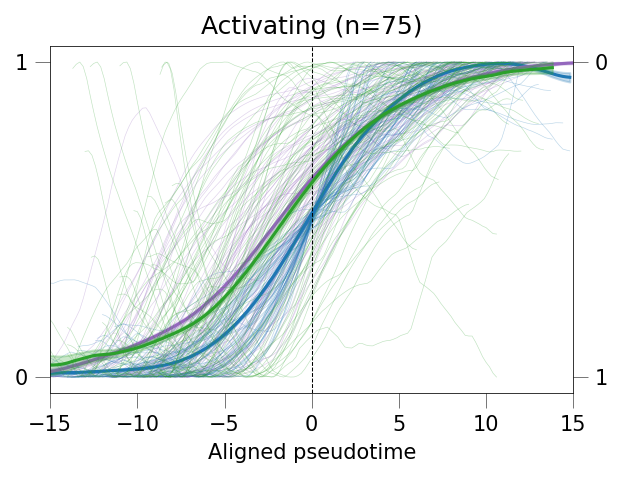

In [62]:
f,ax = plt.subplots(figsize=(4.5,3))

ax1 = ax.twinx()
for i,var_name in enumerate(activating_var_names):
    ax.plot(xhat2d_corrected_rna[i], yhat2d_rna[i], lw=.3, alpha=.3, color=COLORS[0])
    ax.plot(xhat2d_corrected_dam[i], yhat2d_dam[i], lw=.3, alpha=.3, color=COLORS[4])

    ax1.plot(xhat2d_corrected_lb1[i], yhat2d_lb1[i], lw=.3, alpha=.3, color=COLORS[2])

xhat_rna, yhat_rna, yhat_sem_rna = sccu.RNR(X=np.hstack(xhat2d_corrected_rna), 
                                            y=np.hstack(yhat2d_rna),
                                            _RADIUS=1.5, 
                                            step=.2
)
yhat_sem_min = ((yhat_rna - yhat_sem_rna) - (yhat_rna - yhat_sem_rna).min()) / ((yhat_rna + yhat_sem_rna).max() - (yhat_rna - yhat_sem_rna).min())
yhat_sem_plus = ((yhat_rna + yhat_sem_rna) - (yhat_rna - yhat_sem_rna).min()) / ((yhat_rna + yhat_sem_rna).max() - (yhat_rna - yhat_sem_rna).min())
yhat_rna = (yhat_rna - (yhat_rna - yhat_sem_rna).min()) / ((yhat_rna + yhat_sem_rna).max() - (yhat_rna - yhat_sem_rna).min())

ax.plot(xhat_rna, yhat_rna, lw=1.5, color=COLORS[0])
ax.fill_between(xhat_rna, yhat_sem_min, yhat_sem_plus, color=COLORS[0], alpha=.25)

xhat_lb1, yhat_lb1, yhat_sem_lb1 = sccu.RNR(X=np.hstack(xhat2d_corrected_lb1), 
                                            y=np.hstack(yhat2d_lb1),
                                            _RADIUS=1.5, 
                                            step=.2
)
yhat_sem_min = ((yhat_lb1 - yhat_sem_lb1) - (yhat_lb1 - yhat_sem_lb1).min()) / ((yhat_lb1 + yhat_sem_lb1).max() - (yhat_lb1 - yhat_sem_lb1).min())
yhat_sem_plus = ((yhat_lb1 + yhat_sem_lb1) - (yhat_lb1 - yhat_sem_lb1).min()) / ((yhat_lb1 + yhat_sem_lb1).max() - (yhat_lb1 - yhat_sem_lb1).min())
yhat_lb1 = (yhat_lb1 - (yhat_lb1 - yhat_sem_lb1).min()) / ((yhat_lb1 + yhat_sem_lb1).max() - (yhat_lb1 - yhat_sem_lb1).min())

ax1.plot(xhat_lb1, yhat_lb1, lw=1.5, color=COLORS[2])
ax1.fill_between(xhat_lb1, yhat_sem_min, yhat_sem_plus, color=COLORS[2], alpha=.25)

xhat_dam, yhat_dam, yhat_sem_dam = sccu.RNR(X=np.hstack(xhat2d_corrected_dam), 
                                            y=np.hstack(yhat2d_dam),
                                            _RADIUS=1.5, 
                                            step=.2
)
yhat_sem_min = ((yhat_dam - yhat_sem_dam) - (yhat_dam - yhat_sem_dam).min()) / ((yhat_dam + yhat_sem_dam).max() - (yhat_dam - yhat_sem_dam).min())
yhat_sem_plus = ((yhat_dam + yhat_sem_dam) - (yhat_dam - yhat_sem_dam).min()) / ((yhat_dam + yhat_sem_dam).max() - (yhat_dam - yhat_sem_dam).min())
yhat_dam = (yhat_dam - (yhat_dam - yhat_sem_dam).min()) / ((yhat_dam + yhat_sem_dam).max() - (yhat_dam - yhat_sem_dam).min())

ax.plot(xhat_dam, yhat_dam, lw=1.5, color=COLORS[4])
ax.fill_between(xhat_dam, yhat_sem_min, yhat_sem_plus, color=COLORS[4], alpha=.25)
    
ax.set_xlim(-15,15)
ax1.invert_yaxis()

ax.set_xlabel('Aligned pseudotime')
ax.set_yticks([0,1])
ax1.set_yticks([0,1])

ax.axvline(0, lw=.5, ls='--', color='k')
ax.set_title(f"Activating (n={activating_var_names.size})")

In [78]:
min_ywindow = 0.4
max_ywindow = 0.6

xhat_size = 101 #hard-coded, depends on `int(pseudotime.max() / step) + 1)`

xhat2d_corrected_rna = np.zeros((deactivating_var_names.size,xhat_size))
yhat2d_rna = np.zeros((deactivating_var_names.size,xhat_size))

xhat2d_corrected_lb1 = np.zeros((deactivating_var_names.size,xhat_size))
yhat2d_lb1 = np.zeros((deactivating_var_names.size,xhat_size))

xhat2d_corrected_dam = np.zeros((deactivating_var_names.size,xhat_size))
yhat2d_dam = np.zeros((deactivating_var_names.size,xhat_size))


for i,var in enumerate(tqdm(deactivating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime']
    Mc = np.ravel(adata[obs_names,var].layers['count_abundance_genes_from_celseq2_data'].toarray())

    xhat_rna, yhat_rna, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat_rna = sccu.mmscale(yhat_rna)
    window_rna_idx = (yhat_rna >= min_ywindow) & (yhat_rna < max_ywindow)
    xhat2d_corrected_rna[i] = xhat_rna - xhat_rna[window_rna_idx].mean()
    yhat2d_rna[i] = yhat_rna

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime']
    Mc = np.ravel(adata_lb1[:,var].layers['count_abundance_genes_from_celseq2_data'].toarray())

    xhat_rna, yhat_rna, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat_rna = sccu.mmscale(yhat_rna)
    window_rna_idx = (yhat_rna >= min_ywindow) & (yhat_rna < max_ywindow)
    
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var].layers['damid'].toarray())
    _idx = Md > Md.min()

    xhat_lb1, yhat_lb1, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=Md[_idx], 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat_lb1 = sccu.mmscale(yhat_lb1)
    xhat2d_corrected_lb1[i] = xhat_lb1 - xhat_rna[window_rna_idx].mean()
    yhat2d_lb1[i] = yhat_lb1
    

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Mc = np.ravel(adata_dam[:,var].layers['count_abundance_genes_from_celseq2_data'].toarray())

    xhat_rna, yhat_rna, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat_rna = sccu.mmscale(yhat_rna)
    window_rna_idx = (yhat_rna >= min_ywindow) & (yhat_rna < max_ywindow)
    
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var].layers['damid'].toarray())
    _idx = Md > Md.min()

    xhat_dam, yhat_dam, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=Md[_idx], 
                                    _RADIUS=5, 
                                    step=.2
    )
    yhat_dam = sccu.mmscale(yhat_dam)
    xhat2d_corrected_dam[i] = xhat_dam - xhat_rna[window_rna_idx].mean()
    yhat2d_dam[i] = yhat_dam

  0%|          | 0/123 [00:00<?, ?it/s]

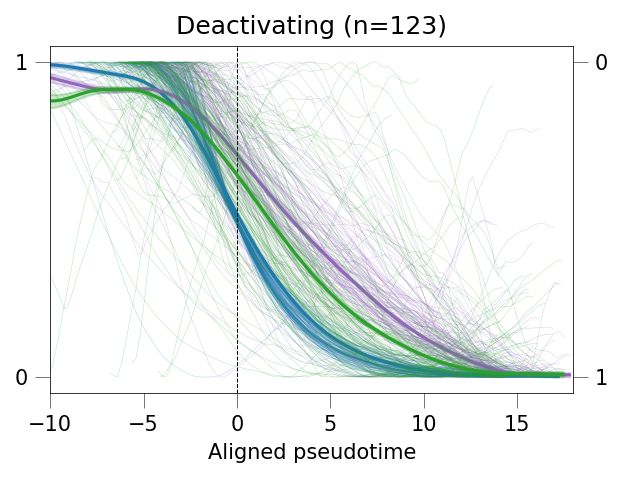

In [98]:
f,ax = plt.subplots(figsize=(4.5,3))

ax1 = ax.twinx()
for i,var_name in enumerate(deactivating_var_names):
    ax.plot(xhat2d_corrected_rna[i], yhat2d_rna[i], lw=.3, alpha=.25, color=COLORS[0])
    ax.plot(xhat2d_corrected_dam[i], yhat2d_dam[i], lw=.3, alpha=.25, color=COLORS[4])

    ax1.plot(xhat2d_corrected_lb1[i], yhat2d_lb1[i], lw=.3, alpha=.25, color=COLORS[2])
    
xhat_rna, yhat_rna, yhat_sem_rna = sccu.RNR(X=np.hstack(xhat2d_corrected_rna), 
                                            y=np.hstack(yhat2d_rna),
                                            _RADIUS=1.5, 
                                            step=.2
)
yhat_sem_min = ((yhat_rna - yhat_sem_rna) - (yhat_rna - yhat_sem_rna).min()) / ((yhat_rna + yhat_sem_rna).max() - (yhat_rna - yhat_sem_rna).min())
yhat_sem_plus = ((yhat_rna + yhat_sem_rna) - (yhat_rna - yhat_sem_rna).min()) / ((yhat_rna + yhat_sem_rna).max() - (yhat_rna - yhat_sem_rna).min())
yhat_rna = (yhat_rna - (yhat_rna - yhat_sem_rna).min()) / ((yhat_rna + yhat_sem_rna).max() - (yhat_rna - yhat_sem_rna).min())

ax.plot(xhat_rna, yhat_rna, lw=1.5, color=COLORS[0])
ax.fill_between(xhat_rna, yhat_sem_min, yhat_sem_plus, color=COLORS[0], alpha=.25)

xhat_lb1, yhat_lb1, yhat_sem_lb1 = sccu.RNR(X=np.hstack(xhat2d_corrected_lb1), 
                                            y=np.hstack(yhat2d_lb1),
                                            _RADIUS=1.5, 
                                            step=.2
)
yhat_sem_min = ((yhat_lb1 - yhat_sem_lb1) - (yhat_lb1 - yhat_sem_lb1).min()) / ((yhat_lb1 + yhat_sem_lb1).max() - (yhat_lb1 - yhat_sem_lb1).min())
yhat_sem_plus = ((yhat_lb1 + yhat_sem_lb1) - (yhat_lb1 - yhat_sem_lb1).min()) / ((yhat_lb1 + yhat_sem_lb1).max() - (yhat_lb1 - yhat_sem_lb1).min())
yhat_lb1 = (yhat_lb1 - (yhat_lb1 - yhat_sem_lb1).min()) / ((yhat_lb1 + yhat_sem_lb1).max() - (yhat_lb1 - yhat_sem_lb1).min())

ax1.plot(xhat_lb1, yhat_lb1, lw=1.5, color=COLORS[2])
ax1.fill_between(xhat_lb1, yhat_sem_min, yhat_sem_plus, color=COLORS[2], alpha=.25)

xhat_dam, yhat_dam, yhat_sem_dam = sccu.RNR(X=np.hstack(xhat2d_corrected_dam), 
                                            y=np.hstack(yhat2d_dam),
                                            _RADIUS=1.5, 
                                            step=.2
)
yhat_sem_min = ((yhat_dam - yhat_sem_dam) - (yhat_dam - yhat_sem_dam).min()) / ((yhat_dam + yhat_sem_dam).max() - (yhat_dam - yhat_sem_dam).min())
yhat_sem_plus = ((yhat_dam + yhat_sem_dam) - (yhat_dam - yhat_sem_dam).min()) / ((yhat_dam + yhat_sem_dam).max() - (yhat_dam - yhat_sem_dam).min())
yhat_dam = (yhat_dam - (yhat_dam - yhat_sem_dam).min()) / ((yhat_dam + yhat_sem_dam).max() - (yhat_dam - yhat_sem_dam).min())

ax.plot(xhat_dam, yhat_dam, lw=1.5, color=COLORS[4])
ax.fill_between(xhat_dam, yhat_sem_min, yhat_sem_plus, color=COLORS[4], alpha=.25)
    
ax.set_xlim(-10,18)
ax1.invert_yaxis()

ax.set_title(f"Deactivating (n={deactivating_var_names.size})")
ax.set_xlabel('Aligned pseudotime')
ax.set_yticks([0,1])
ax1.set_yticks([0,1])

ax.axvline(0, lw=.5, ls='--', color='k')

In [80]:
min_ywindow = 0.4
max_ywindow = 0.6

X_window_deactivating = np.zeros((len(deactivating_var_names),3))

for i,var in enumerate(tqdm(deactivating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime']
    Mc = np.ravel(adata[obs_names,var].layers['count_abundance_genes_from_celseq2_data'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_deactivating[i,0] = xhat[window_idx].mean()

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var].layers['damid'].toarray())
    _idx = Md > Md.min()

    xhat, yhat, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=Md[_idx], 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_deactivating[i,1] = xhat[window_idx].mean()

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var].layers['damid'].toarray())
    _idx = Md > Md.min()

    xhat, yhat, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=Md[_idx], 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_deactivating[i,2] = xhat[window_idx].mean()

  0%|          | 0/123 [00:00<?, ?it/s]

In [82]:
min_ywindow = 0.4
max_ywindow = 0.6

X_window_deactivating_rna = np.zeros((len(deactivating_var_names),3))

for i,var in enumerate(tqdm(deactivating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime']
    Mc = np.ravel(adata[obs_names,var].layers['count_abundance_genes_from_celseq2_data'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_deactivating_rna[i,0] = xhat[window_idx].mean()

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var].layers['count_abundance_genes_from_celseq2_data'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_deactivating_rna[i,1] = xhat[window_idx].mean()

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var].layers['count_abundance_genes_from_celseq2_data'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=4, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_deactivating_rna[i,2] = xhat[window_idx].mean()

  0%|          | 0/123 [00:00<?, ?it/s]

Text(1.0, 11.757, 'p=7.2e-22')

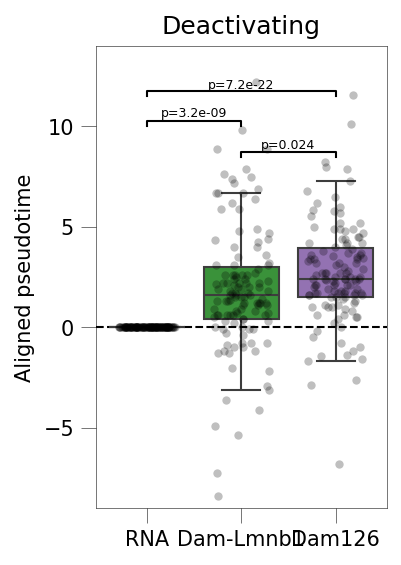

In [90]:
X = np.tile(['RNA','Dam-Lmnb1','Dam126'], len(deactivating_var_names))
y_norm = np.hstack(X_window_deactivating) - np.hstack(X_window_deactivating_rna)

f, ax = plt.subplots(figsize=(2.5,4))

sns.boxplot(x=X, y=y_norm, fliersize=0, palette=[COLORS[0],COLORS[2],COLORS[4]])#, order=['Dam126','Dam-Lmnb1','RNA'])
sns.stripplot(x=X, y=y_norm, jitter=.3, size=4, color='k', alpha=.25, order=['Dam126','Dam-Lmnb1','RNA'])

ax.set_ylabel('Aligned pseudotime')
ax.set_title('Deactivating')

ax.axhline(0, lw=1, ls='--', color='k')

ymin, ymax = -9, 14
ax.set_ylim(ymin,ymax)

#ttest RNA vs Dam-Lmnb1
p = stats.ttest_ind(y_norm[X=='RNA'], y_norm[X=='Dam-Lmnb1'], equal_var=False)[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 4, .25
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.1, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest Dam-Lmnb1 vs Dam126
p = stats.ttest_ind(y_norm[X=='Dam-Lmnb1'], y_norm[X=='Dam126'], equal_var=False)[1]

#annotate
x1, x2 = 1, 2
y0, h = ymax - 5.5, .25
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest RNA vs Dam126
p = stats.ttest_ind(y_norm[X=='RNA'],y_norm[X=='Dam126'], equal_var=False)[1]

#annotate
x1, x2 = 0, 2
y0, h = ymax - 2.5, .25
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

In [85]:
min_ywindow = 0.4
max_ywindow = 0.6

X_window_activating = np.zeros((len(activating_var_names),3))

for i,var in enumerate(tqdm(activating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime']
    Mc = np.ravel(adata[obs_names,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating[i,0] = xhat[window_idx].mean()

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var].layers['Md'].toarray())
    #_idx = Md > Md.min()

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating[i,1] = xhat[window_idx].mean()

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var].layers['Md'].toarray())
    #_idx = Md > Md.min()

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating[i,2] = xhat[window_idx].mean()

  0%|          | 0/75 [00:00<?, ?it/s]

In [86]:
min_ywindow = 0.4
max_ywindow = 0.6

X_window_activating_rna = np.zeros((len(activating_var_names),3))

for i,var in enumerate(tqdm(activating_var_names)):
    #expression
    obs_names = adata.obs_names[~adata.obs['monocle_pseudotime'].isna()]
    X = adata[obs_names].obs['monocle_pseudotime']
    Mc = np.ravel(adata[obs_names,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating_rna[i,0] = xhat[window_idx].mean()

    #Dam-Lmnb1
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating_rna[i,1] = xhat[window_idx].mean()

    #Dam126
    X = adata_dam.obs['monocle_pseudotime']
    Md = np.ravel(adata_dam[:,var].layers['Mc'].toarray())

    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    yhat = sccu.mmscale(yhat)
    window_idx = (yhat >= min_ywindow) & (yhat < max_ywindow)
    X_window_activating_rna[i,2] = xhat[window_idx].mean()

  0%|          | 0/75 [00:00<?, ?it/s]

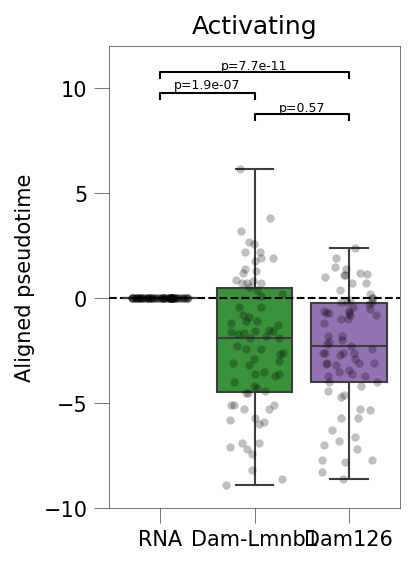

In [91]:
X = np.tile(['RNA','Dam-Lmnb1','Dam126'], len(activating_var_names))
y_norm = np.log2(np.hstack(X_window_activating) / np.hstack(X_window_activating_rna))
y_norm = np.hstack(X_window_activating) - np.hstack(X_window_activating_rna)

f, ax = plt.subplots(figsize=(2.5,4))

sns.boxplot(x=X, y=y_norm, palette=[COLORS[0],COLORS[2],COLORS[4]])#, order=['Dam126','Dam-Lmnb1','RNA'])
sns.stripplot(x=X, y=y_norm, jitter=.3, size=4, color='k', alpha=.25, order=['Dam126','Dam-Lmnb1','RNA'])

ax.set_ylabel('Aligned pseudotime')
ax.set_title('Activating')

ax.axhline(0, lw=1, ls='--', color='k')

ymin, ymax = -10, 12
ax.set_ylim(ymin,ymax)

#ttest RNA vs Dam-Lmnb1
p = stats.ttest_ind(y_norm[X=='RNA'], y_norm[X=='Dam-Lmnb1'], equal_var=False)[1]

#annotate
x1, x2 = 0, 1
y0, h = ymax - 2.5, .25
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.1, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest Dam-Lmnb1 vs Dam126
p = stats.ttest_ind(y_norm[X=='Dam-Lmnb1'], y_norm[X=='Dam126'], equal_var=False)[1]

#annotate
x1, x2 = 1, 2
y0, h = ymax - 3.5, .25
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

#ttest RNA vs Dam126
p = stats.ttest_ind(y_norm[X=='RNA'],y_norm[X=='Dam126'], equal_var=False)[1]

#annotate
x1, x2 = 0, 2
y0, h = ymax - 1.5, .25
ax.plot([x1, x1, x2, x2], [y0, y0+h, y0+h, y0], lw=1, c='k')
ax.text((x1+x2)*.5, y0+h+.007, f"p={p:.2}", ha='center', va='bottom', c='k', fontsize=6)

ax.set_yticks(np.arange(-10,11,5))